In [279]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from scipy.stats import mode
import csv
import matplotlib.dates
from datetime import *
from sklearn import linear_model
from sklearn.preprocessing import *
from sklearn import ensemble
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.externals import joblib
from fbprophet import Prophet

In [280]:
#导入训练数据
train_data = pd.read_csv('fusai_A_fullfilling_train_feature_set.csv')

print(train_data.head(10))

   date  brand  cnt  day_of_week  week  guess_date  date_year  date_month  \
0     1      1   31            2     0  2013-01-01       2013           1   
1     1      6    6            2     0  2013-01-01       2013           1   
2     1      9   15            2     0  2013-01-01       2013           1   
3     2      9    0            3     0  2013-01-02       2013           1   
4     2      8    0            3     0  2013-01-02       2013           1   
5     2      3    0            3     0  2013-01-02       2013           1   
6     2      2    0            3     0  2013-01-02       2013           1   
7     2      7   30            3     0  2013-01-02       2013           1   
8     2      6    6            3     0  2013-01-02       2013           1   
9     2      4   20            3     0  2013-01-02       2013           1   

   date_property guess_date_str    ...     brand_1 brand_2  brand_3  brand_4  \
0              2     2013-01-01    ...           1       0        0     

In [281]:
#根据prophet定义训练集
df_allBrand = train_data
df_allBrand['guess_date'] = df_allBrand['guess_date'].map(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df_allBrand.rename(columns = {'guess_date':'ds', 'cnt':'y', 'brand':'brand'}, inplace=True)
df_brand9 = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 9) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand9['y'] = df_brand9['y'].map(lambda x: None if x > 1500 else x)

#定义最大值和最小值
df_brand9['cap'] = 1800
df_brand9['floor'] = -500

print(df_brand9.head(10))

            ds   y  day_of_week_1  day_of_week_2  day_of_week_3  \
2   2013-01-01  15              0              1              0   
3   2013-01-02   0              0              0              1   
16  2013-01-03   0              0              0              0   
100 2013-01-12  31              0              0              0   
106 2013-01-13  13              0              0              0   
163 2013-01-19  46              0              0              0   
172 2013-01-20  40              0              0              0   
224 2013-01-26  46              0              0              0   
233 2013-01-27   0              0              0              0   
288 2013-02-02  92              0              0              0   

     day_of_week_4  day_of_week_5  day_of_week_6  day_of_week_7  \
2                0              0              0              0   
3                0              0              0              0   
16               1              0              0             

In [282]:
#为模型添加节假日特征
#元旦
NewYearDay = pd.DataFrame({
  'holiday': 'NewYearDay',
  'ds': pd.to_datetime(['2013-01-01', '2013-01-02', '2013-01-03',
                        '2014-01-01', 
                        '2015-01-01', '2015-01-02', '2015-01-03',
                        '2016-01-01', '2016-01-02', '2016-01-03'])
})

#春节
ChineseNewYearDay = pd.DataFrame({
  'holiday': 'ChineseNewYearDay',
  'ds': pd.to_datetime(['2013-02-09', '2013-02-10', '2013-02-11', '2013-02-12', '2013-02-13', '2013-02-14', '2013-02-15',
                        '2014-01-31', '2014-02-01', '2014-02-03', '2014-02-04', '2014-02-05', '2014-02-06', '2014-05-02', 
                        '2015-02-18', '2015-02-19', '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23', '2015-02-24',
                        '2016-02-07', '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13'])
})

#国庆节
NationalDay = pd.DataFrame({
  'holiday': 'NationalDay',
  'ds': pd.to_datetime(['2013-10-01', '2013-10-02', '2013-10-03', '2013-10-04', '2013-10-05', '2013-10-06', '2013-10-07',
                        '2014-10-01', '2014-10-02', '2014-10-03', '2014-10-04', '2014-10-05', '2014-10-06', '2014-10-07', 
                        '2015-10-01', '2015-10-02', '2015-10-03', '2015-10-04', '2015-10-05', '2015-10-06', '2015-10-07',
                        '2016-10-01', '2016-10-02', '2016-10-03', '2016-10-04', '2016-10-05', '2016-10-06', '2016-10-07'])
})

#劳动节
MayDay = pd.DataFrame({
  'holiday': 'MayDay',
  'ds': pd.to_datetime(['2013-04-29', '2013-04-30', '2013-05-01',
                        '2014-05-01', '2014-05-02', '2014-05-03',  
                        '2015-05-01', '2015-05-02', '2015-05-03',
                        '2016-05-01', '2016-05-02', '2016-04-30'])
})

#清明节
ChingMingDay = pd.DataFrame({
  'holiday': 'ChingMingDay',
  'ds': pd.to_datetime(['2013-04-04', '2013-04-05', '2013-04-06',
                        '2014-04-05', '2014-04-06', '2014-04-07',  
                        '2015-04-04', '2015-04-05', '2015-04-06',
                        '2016-04-02', '2016-04-03', '2016-04-04'])
})

#端午节
DragonBoatDay = pd.DataFrame({
  'holiday': 'DragonBoatDay',
  'ds': pd.to_datetime(['2013-06-10', '2013-06-11', '2013-06-12',
                        '2014-05-31', '2014-06-01', '2014-06-02',  
                        '2015-06-20', '2015-06-21', '2015-06-22',
                        '2016-06-09', '2016-06-10', '2016-06-11'])
})

#中秋节
MidAutumnDay = pd.DataFrame({
  'holiday': 'MidAutumnDay',
  'ds': pd.to_datetime(['2013-09-19', '2013-09-20', '2013-09-21',
                        '2014-09-06', '2014-09-07', '2014-09-08',  
                        '2015-09-26', '2015-09-27',
                        '2015-09-03', '2015-09-04', '2015-09-05',
                        '2016-09-15', '2016-09-16', '2016-09-17'])
})

holidays = pd.concat((NewYearDay, ChineseNewYearDay, NationalDay, MayDay, ChingMingDay, DragonBoatDay, MidAutumnDay))


In [283]:
#手动设置changepoints集合
changepoints = ['2013-10-01', '2014-10-01', '2015-10-01']

In [284]:
#定义prophet模型和预测集
# m = Prophet()
m = Prophet(growth = 'logistic', holidays = holidays, changepoints = changepoints, changepoint_prior_scale = 0.5, 
           interval_width = 0.95)
m.add_seasonality(name = 'weekly', period = 7, fourier_order = 3)

m.add_regressor('day_of_week_1')
m.add_regressor('day_of_week_2')
m.add_regressor('day_of_week_3')
m.add_regressor('day_of_week_4')
m.add_regressor('day_of_week_5')
m.add_regressor('day_of_week_6')
m.add_regressor('day_of_week_7')

# m.add_regressor('date_property_0')
# m.add_regressor('date_property_1')
# m.add_regressor('date_property_2')

m.add_regressor('is_newYearDay')
m.add_regressor('is_NationalDay')
m.add_regressor('is_ChineseNewYearDay')

# m.add_regressor('after_restday_one')
# m.add_regressor('after_holiday_one')
m.add_regressor('is_holi_restday')
m.add_regressor('isHolidayWeekend')
m.add_regressor('isPureWeekend')

m.fit(df_brand9)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [285]:
#导入预测数据集
# test_data = pd.read_csv('fusai_A_test_feature_set.csv')
test_data = pd.read_csv('fusai_A_test_feature_set.csv')
test_data['guess_date'] = test_data['guess_date'].map(lambda x: datetime.strptime(x, "%Y-%m-%d"))
test_data.rename(columns = {'guess_date':'ds'}, inplace=True)

test_data_brand9 = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 9) & (test_data.date_property != 0)]
# test_data_brand9 = test_data[['guess_date']][test_data.brand == 9]
test_data_brand9 = pd.concat([df_brand9.drop('y', 1), test_data_brand9])
test_data_brand9['cap'] = 1800
test_data_brand9['floor'] = -500
print(test_data_brand9.head(10))
# future['day_of_week_1'] = future['ds'].map(lambda x: test_data_brand9['day_of_week_1'][test_data_brand9.guess_date == x].values)
# print(future.tail(10))

     after_holiday_one  after_restday_one   cap  date_property_0  \
2                    0                  0  1800                0   
3                    0                  0  1800                0   
16                   0                  0  1800                0   
100                  0                  0  1800                0   
106                  0                  0  1800                0   
163                  0                  0  1800                0   
172                  0                  0  1800                0   
224                  0                  0  1800                0   
233                  0                  0  1800                0   
288                  0                  0  1800                0   

     date_property_1  date_property_2  day_of_week_1  day_of_week_2  \
2                  0                1              0              1   
3                  0                1              0              0   
16                 0                1 

In [286]:
forcast = m.predict(test_data_brand9)
print(forcast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast.ds < '2016-01-10') & (forcast.ds > '2016-01-01')])


            ds        yhat  yhat_lower  yhat_upper
317 2015-10-02   34.973484 -117.925640  190.322328
318 2015-10-03   78.429437  -59.886355  226.707926
319 2015-10-04  -30.452656 -184.774594  121.827084
320 2015-10-05   25.018136 -124.400461  187.522317
321 2015-10-06   36.689930 -124.308639  193.092521
322 2015-10-07   45.369637 -115.480289  205.705815
323 2015-10-11    7.400120 -143.608918  163.918370
324 2015-10-17  139.259643  -14.795142  303.503150
325 2015-10-18   36.009943 -122.575645  193.656479
326 2015-10-24  170.346772   11.218209  324.100114
327 2015-10-25   65.580749  -70.126374  222.679099
328 2015-10-31  181.401653   16.536960  343.947655
329 2015-11-01   72.529108  -94.577361  216.416572
330 2015-11-07  164.399971    8.591523  324.230535
331 2015-11-08   52.327537 -101.779278  208.768425
332 2015-11-14  134.198893  -25.316139  284.452398
333 2015-11-15   22.143099 -138.175351  185.777851
334 2015-11-21  112.701267  -41.065132  272.378422
335 2015-11-22    3.144070 -147

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


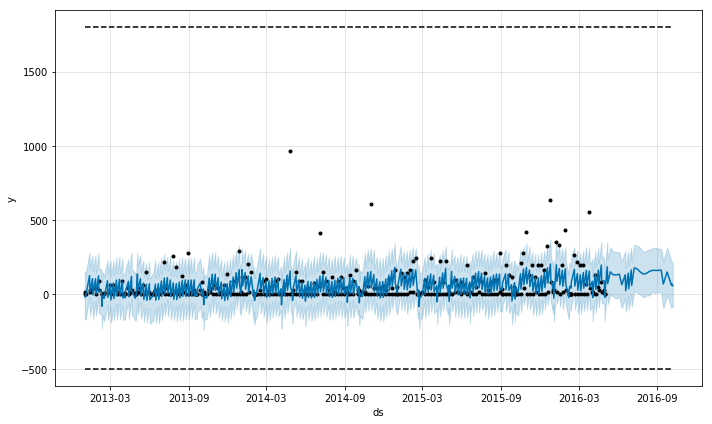

In [287]:
m.plot(forcast)

In [351]:
#定义根据date_property是否为0，预测数据的函数
def predictByProphet(df_train, df_test, holidays, cap, floor, none_value, changepoint_prior_scale,
                            interval_width, regressor_set, changepoints):
    #处理训练集相关数据
    df_train['y'] = df_train['y'].map(lambda x: None if x > none_value else x)
    #定义最大值和最小值
    df_train['cap'] = cap
    df_train['floor'] = floor
    
    #定义prophet模型和预测集
    m = Prophet(growth = 'logistic', holidays = holidays, changepoints = changepoints,
                changepoint_prior_scale = changepoint_prior_scale, interval_width = interval_width)
    m.add_seasonality(name = 'weekly', period = 7, fourier_order = 3)
    
    #添加额外特征
    for regressor_future in regressor_set:
        m.add_regressor(regressor_future)
        
    m.fit(df_train)
    
    #处理测试集相关数据
    test_data = pd.concat([df_train.drop('y', 1), df_test])
    test_data['cap'] = cap
    test_data['floor'] = floor
    
    forcast = m.predict(test_data)
    return m, forcast

df_brand9_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 9) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand9_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand9_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand9_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 9) & (test_data.date_property != 0)]
m_brand9_restday, forcast_brand9_restday = predictByProphet(df_brand9_restday, test_data_brand9_restday, holidays, 500, -500, 500, 0.5,
                0.95, df_brand9_restday_regressor_set, brand9_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
317 2015-10-02   14.196043 -100.578003  117.044820
318 2015-10-03   72.739258  -24.393716  178.766560
319 2015-10-04  -21.018944 -124.484222   82.255046
320 2015-10-05   25.333424  -79.129476  135.033306
321 2015-10-06   36.433872  -70.760300  144.849977
322 2015-10-07   46.853422  -59.426295  155.008287
323 2015-10-11   27.875426  -70.299971  135.993721
324 2015-10-17  131.349442   24.148850  244.307876
325 2015-10-18   38.804064  -67.932008  146.454968
326 2015-10-24  138.930106   28.289892  252.859706
327 2015-10-25   45.269729  -62.788608  144.461795
328 2015-10-31  137.139136   30.667549  249.144886
329 2015-11-01   42.073686  -67.931133  150.721233
330 2015-11-07  127.415411   26.219675  236.314052
331 2015-11-08   31.727717  -77.545329  142.935876
332 2015-11-14  116.636348   17.364023  221.084173
333 2015-11-15   21.383747  -86.749957  134.711756
334 2015-11-21  110.924389    8.164224  215.265642
335 2015-11-22   16.651047  -88

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


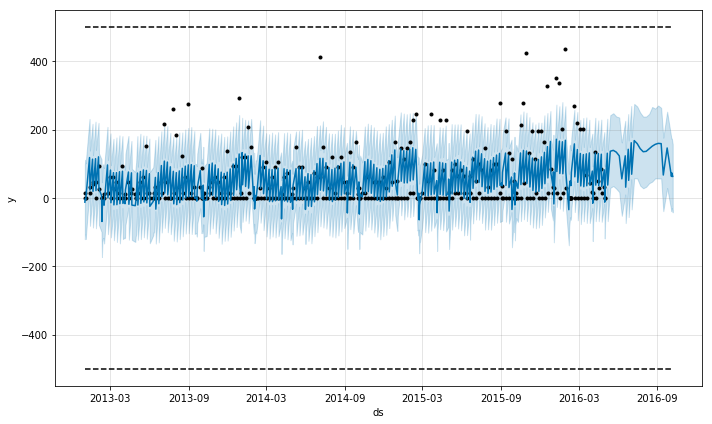

In [352]:
print(forcast_brand9_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand9_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand9_restday.ds < '2016-01-10') & (forcast_brand9_restday.ds > '2016-01-01')])
m_brand9_restday.plot(forcast_brand9_restday)

In [353]:
df_brand9_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 9) 
                                          & (train_data.date_property == 0)]
df_brand9_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand9_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand9_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 9) & (test_data.date_property == 0)]
m_brand9_workday, forcast_brand9_workday = predictByProphet(df_brand9_workday, test_data_brand9_workday, holidays, 1400, -100, 1800, 0.5,
                0.95, df_brand9_workday_regressor_set, brand9_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower   yhat_upper
841 2016-05-18  464.832623  -26.352802   940.725386
842 2016-05-19  335.109973 -161.424219   839.902660
843 2016-05-20  437.758539  -36.326766   888.782286
844 2016-05-23  464.680367  -30.532174   948.790799
845 2016-05-24  492.307209    8.928093   967.636884
846 2016-05-25  423.626865  -35.717410   912.226899
847 2016-05-26  294.127146 -188.959681   743.557324
848 2016-05-27  397.269601 -144.652492   865.751716
849 2016-05-30  427.229506  -57.816389   915.733732
850 2016-05-31  456.359569  -20.141725   921.822885
851 2016-06-01  389.411150  -88.194614   866.927393
852 2016-06-02  261.860679 -235.576898   799.826631
853 2016-06-03  367.157324  -96.300261   820.990999
854 2016-06-06  404.669585  -70.831570   885.036355
855 2016-06-07  436.627998  -25.861833   939.375107
856 2016-06-08  372.634157 -126.621986   857.300332
857 2016-06-12  479.134117   -6.641282   956.998025
858 2016-06-13  434.213792  -92.449931   923.645372
859 2016-06-

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


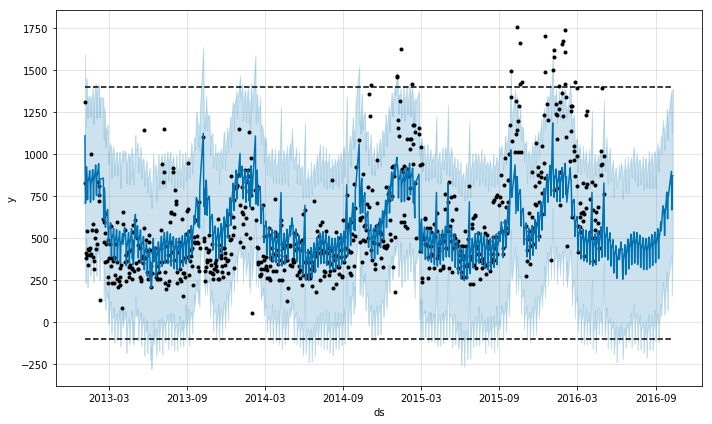

In [354]:
print(forcast_brand9_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand9_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand9_workday.ds < '2016-01-10') & (forcast_brand9_workday.ds > '2016-01-01')])
m_brand9_workday.plot(forcast_brand9_workday)

In [355]:
brand9_result = pd.concat([forcast_brand9_workday, forcast_brand9_restday])
brand9_result = brand9_result.sort_values(by='ds', ascending=True)
print(brand9_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower   yhat_upper
862 2016-06-17  368.503034  -71.738927   855.915869
396 2016-06-18  123.059667    9.741501   225.568577
397 2016-06-19   31.195752  -73.860590   141.088437
863 2016-06-20  424.231208  -74.157724   927.099084
864 2016-06-21  461.938243  -31.665964   976.452439
865 2016-06-22  403.450415  -68.919046   898.948036
866 2016-06-23  284.177707 -146.486096   772.562240
867 2016-06-24  397.503395  -62.554155   903.851347
398 2016-06-25  142.149467   30.323965   245.153531
399 2016-06-26   51.205704  -56.322910   167.934249
868 2016-06-27  456.973167   -6.018989   936.743496
869 2016-06-28  495.340283  -16.289753   986.140926
870 2016-06-29  437.207910  -43.344977   895.013314
871 2016-06-30  317.984252 -117.950555   766.639216
872 2016-07-01  431.054156  -44.624040   908.550465
400 2016-07-02  161.295366   54.515427   268.801354
401 2016-07-03   69.150093  -33.771467   177.970995
873 2016-07-04  487.993576    5.330154   955.663701
874 2016-07-

In [293]:
df_brand1_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 1) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand1_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand1_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand1_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 1) & (test_data.date_property != 0)]
m_brand1_restday, forcast_brand1_restday = predictByProphet(df_brand1_restday, test_data_brand1_restday, holidays, 1000, -100, 200, 0.5,
                0.95, df_brand1_restday_regressor_set, brand1_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
307 2015-09-03   0.215108  -50.079173   53.053534
308 2015-09-04   4.229615  -46.978806   57.064087
309 2015-09-05  13.313461  -40.525975   67.338440
310 2015-09-12  44.653448   -8.488840   96.825711
311 2015-09-13  10.498895  -45.041048   68.018802
312 2015-09-19  53.316456    3.439659  106.176878
313 2015-09-20  18.786031  -34.312882   67.726784
314 2015-09-26  34.037489  -14.925617   85.679402
315 2015-09-27   2.017418  -51.307438   52.994455
316 2015-10-01  13.853048  -38.100956   64.906851
317 2015-10-02  10.784540  -39.195942   63.284336
318 2015-10-03  20.982377  -35.519010   73.230603
319 2015-10-04 -15.210454  -66.650474   38.655013
320 2015-10-05   5.930619  -46.057489   57.961590
321 2015-10-06   7.284244  -41.317799   55.251089
322 2015-10-07   3.337989  -50.089282   55.229679
323 2015-10-11  13.070328  -39.121719   66.155055
324 2015-10-17  43.259440   -9.715601  102.802321
325 2015-10-18   6.973549  -45.910831   61.196290


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


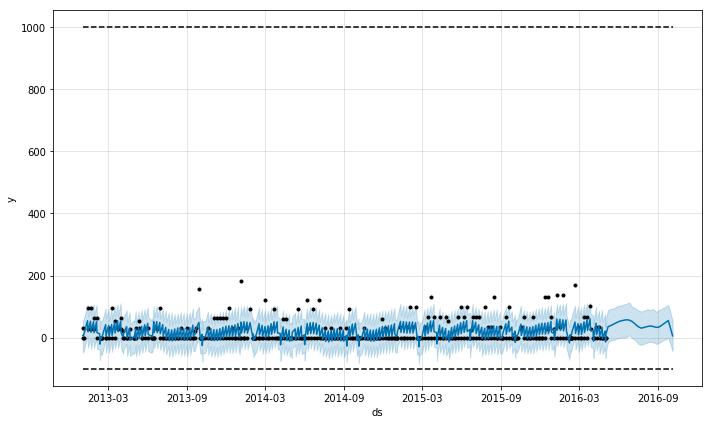

In [294]:
print(forcast_brand1_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand1_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand1_restday.ds < '2016-01-10') & (forcast_brand1_restday.ds > '2016-01-01')])
m_brand1_restday.plot(forcast_brand1_restday)

In [295]:
df_brand1_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 1) 
                                          & (train_data.date_property == 0)]
df_brand1_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand1_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand1_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 1) & (test_data.date_property == 0)]
m_brand1_workday, forcast_brand1_workday = predictByProphet(df_brand1_workday, test_data_brand1_workday, holidays, 1800, -500, 1500, 0.5,
                0.95, df_brand1_workday_regressor_set, brand1_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
840 2016-05-17  427.830624  165.987471  710.703846
841 2016-05-18  387.948777  148.909744  629.219965
842 2016-05-19  321.843007   62.590736  564.607686
843 2016-05-20  359.069172  120.000301  602.617839
844 2016-05-23  429.361464  164.249547  677.112271
845 2016-05-24  420.191827  173.470175  690.847059
846 2016-05-25  380.768709  126.526929  640.678505
847 2016-05-26  314.956388   52.513051  571.536582
848 2016-05-27  352.289707   95.121433  607.736247
849 2016-05-30  421.751824  145.531030  684.776179
850 2016-05-31  411.970544  156.715460  660.470953
851 2016-06-01  371.821529  121.647571  618.438705
852 2016-06-02  305.216138   64.782354  550.147048
853 2016-06-03  341.744246   83.652180  596.538697
854 2016-06-06  409.343936  136.186752  659.767476
855 2016-06-07  399.343527  131.750119  642.078191
856 2016-06-08  359.280281  106.928783  623.719707
857 2016-06-12  553.746469  290.563840  811.610004
858 2016-06-13  459.947833  174

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


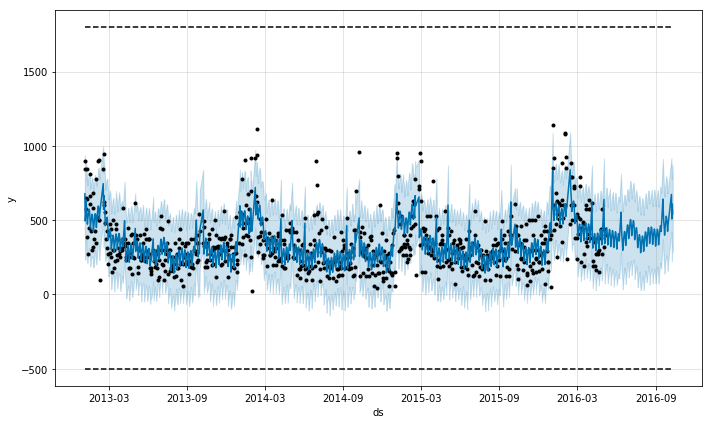

In [296]:
print(forcast_brand1_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand1_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand1_workday.ds < '2016-01-10') & (forcast_brand1_workday.ds > '2016-01-01')])
m_brand1_workday.plot(forcast_brand1_workday)

In [297]:
brand1_result = pd.concat([forcast_brand1_workday, forcast_brand1_restday])
brand1_result = brand1_result.sort_values(by='ds', ascending=True)
print(brand1_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower  yhat_upper
854 2016-06-06  409.343936  136.186752  659.767476
855 2016-06-07  399.343527  131.750119  642.078191
856 2016-06-08  359.280281  106.928783  623.719707
857 2016-06-12  553.746469  290.563840  811.610004
858 2016-06-13  459.947833  174.175164  716.378958
859 2016-06-14  396.034261  140.128305  657.633974
860 2016-06-15  359.087610  109.327206  611.397077
861 2016-06-16  296.441301   35.097648  557.267221
862 2016-06-17  337.675602   78.765966  605.381747
393 2016-06-18   57.537235    1.137047  109.038817
863 2016-06-20  423.396279  181.586540  672.142448
864 2016-06-21  420.483265  150.738934  670.295653
865 2016-06-22  387.828329  146.777755  632.395024
866 2016-06-23  329.245021   69.324930  602.907782
867 2016-06-24  374.200888  118.924977  635.238351
394 2016-06-25   56.479410    7.822919  113.582284
868 2016-06-27  467.974602  204.824743  709.447972
869 2016-06-28  466.397777  218.578428  700.112869
870 2016-06-29  434.281404  189

In [298]:
df_brand2_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 2) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand2_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand2_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand2_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 2) & (test_data.date_property != 0)]
m_brand2_restday, forcast_brand2_restday = predictByProphet(df_brand2_restday, test_data_brand2_restday, holidays, 500, -100, 200, 0.5,
                0.95, df_brand2_restday_regressor_set, brand2_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
304 2015-08-29  31.653183  -22.750624   82.679445
305 2015-08-30  -0.613029  -56.438368   50.493192
306 2015-09-03   4.476665  -47.039908   55.437978
307 2015-09-04   3.125019  -46.521307   58.688756
308 2015-09-05  17.369205  -36.257295   68.017966
309 2015-09-12  47.130030   -9.293566  102.492488
310 2015-09-13  13.501098  -38.722576   68.833820
311 2015-09-19  42.262106  -10.132026   95.066925
312 2015-09-20   7.423834  -43.466475   58.344092
313 2015-09-26  15.369872  -29.640893   65.189733
314 2015-09-27 -19.170668  -71.874985   36.391092
315 2015-10-01  12.253795  -40.672282   63.890315
316 2015-10-02   4.737121  -51.080546   55.766929
317 2015-10-03  22.274803  -32.008731   74.759402
318 2015-10-04 -10.979308  -62.678051   40.352109
319 2015-10-05   5.988041  -50.401312   55.486521
320 2015-10-06   9.590229  -43.387915   62.063692
321 2015-10-07  17.055130  -34.745981   70.472345
322 2015-10-11   1.897248  -51.248598   55.780220


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


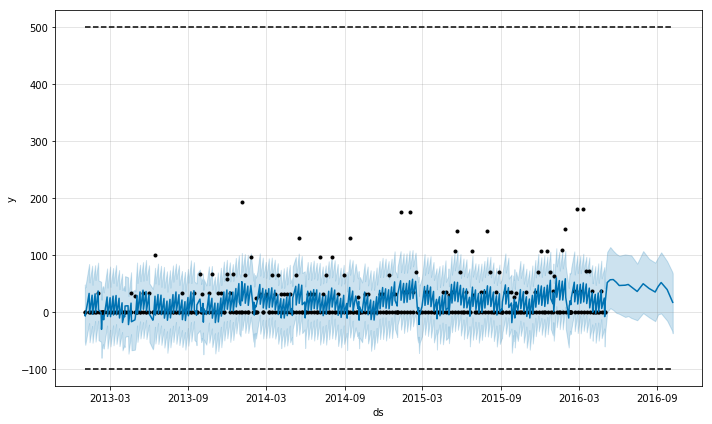

In [299]:
print(forcast_brand2_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand2_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand2_restday.ds < '2016-01-10') & (forcast_brand1_restday.ds > '2016-01-01')])
m_brand2_restday.plot(forcast_brand2_restday)

In [300]:
df_brand2_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 2) 
                                          & (train_data.date_property == 0)]
df_brand2_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand2_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand2_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 2) & (test_data.date_property == 0)]
m_brand2_workday, forcast_brand2_workday = predictByProphet(df_brand2_workday, test_data_brand2_workday, holidays, 1500, -200, 800, 0.5,
                0.95, df_brand2_workday_regressor_set, brand2_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
840 2016-05-17  342.151580  142.473170  554.718778
841 2016-05-18  317.355701   96.163347  548.255853
842 2016-05-19  241.115917   29.567946  457.062503
843 2016-05-20  276.167709   62.083599  485.616339
844 2016-05-23  290.500259   86.053930  516.670436
845 2016-05-24  313.316910  101.898372  533.429566
846 2016-05-25  287.460679   94.347225  497.997239
847 2016-05-26  210.559038   -2.105797  417.541021
848 2016-05-27  245.333759   16.873361  452.809733
849 2016-05-30  260.922235   67.607509  471.694196
850 2016-05-31  284.757719   87.153431  499.884907
851 2016-06-01  260.165253   50.421305  481.080620
852 2016-06-02  184.736823  -17.758271  385.471629
853 2016-06-03  221.158427   22.241803  430.187913
854 2016-06-06  242.384484   45.560872  458.517062
855 2016-06-07  268.225357   58.376276  474.609267
856 2016-06-08  245.654572   46.030221  468.122257
857 2016-06-12  344.558318  129.828003  560.945765
858 2016-06-13  303.247420   84

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


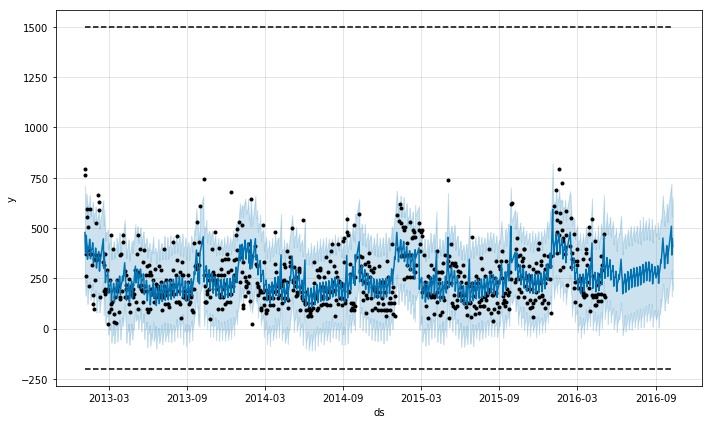

In [301]:
print(forcast_brand2_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand2_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand2_workday.ds < '2016-01-10') & (forcast_brand2_workday.ds > '2016-01-01')])
m_brand2_workday.plot(forcast_brand2_workday)

In [302]:
brand2_result = pd.concat([forcast_brand2_workday, forcast_brand2_restday])
brand2_result = brand2_result.sort_values(by='ds', ascending=True)
print(brand2_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower  yhat_upper
853 2016-06-03  221.158427   22.241803  430.187913
391 2016-06-04   46.105183   -3.701070   98.316849
854 2016-06-06  242.384484   45.560872  458.517062
855 2016-06-07  268.225357   58.376276  474.609267
856 2016-06-08  245.654572   46.030221  468.122257
857 2016-06-12  344.558318  129.828003  560.945765
858 2016-06-13  303.247420   84.301996  507.893647
859 2016-06-14  265.088173   64.099648  463.603270
860 2016-06-15  244.167634   19.653278  451.624959
861 2016-06-16  172.315237  -32.874531  369.175601
862 2016-06-17  212.193994  -13.045202  427.944160
392 2016-06-18   46.631805   -9.165306  100.683876
863 2016-06-20  242.910907   29.793683  452.518522
864 2016-06-21  271.583249   68.107381  470.970966
865 2016-06-22  251.665118   20.538997  467.426431
866 2016-06-23  180.719989  -15.585313  400.794567
867 2016-06-24  221.409668   12.316960  427.243382
393 2016-06-25   47.951540   -7.601117   99.722182
868 2016-06-27  253.962665   48

In [303]:
df_brand3_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 3) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand3_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand3_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand3_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 3) & (test_data.date_property != 0)]
m_brand3_restday, forcast_brand3_restday = predictByProphet(df_brand3_restday, test_data_brand3_restday, holidays, 500, -100, 250, 0.5,
                0.95, df_brand3_restday_regressor_set, brand3_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
308 2015-09-05  21.790537  -30.155399   70.866729
309 2015-09-12  37.970530   -7.592455   85.293213
310 2015-09-13   4.015435  -44.862723   54.029157
311 2015-09-19  34.369163  -14.980552   83.176679
312 2015-09-20  -0.225607  -49.771493   52.270139
313 2015-09-26  11.863437  -36.255804   61.913386
314 2015-09-27 -19.184526  -68.464731   32.771169
315 2015-10-01  15.722108  -31.695833   66.247925
316 2015-10-02   0.444980  -47.251014   53.959326
317 2015-10-03  14.755885  -31.953705   66.215502
318 2015-10-04 -19.058218  -69.267109   27.608962
319 2015-10-05  -3.126332  -51.962166   43.582358
320 2015-10-06   2.010723  -45.388805   55.183647
321 2015-10-07   4.035236  -47.167898   48.162905
322 2015-10-11  -7.154415  -54.913994   41.132956
323 2015-10-17  32.463170  -14.903800   79.586876
324 2015-10-18  -0.339764  -54.074525   51.823129
325 2015-10-24  36.981680  -12.790604   87.463830
326 2015-10-25   3.436439  -44.954637   53.125394


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


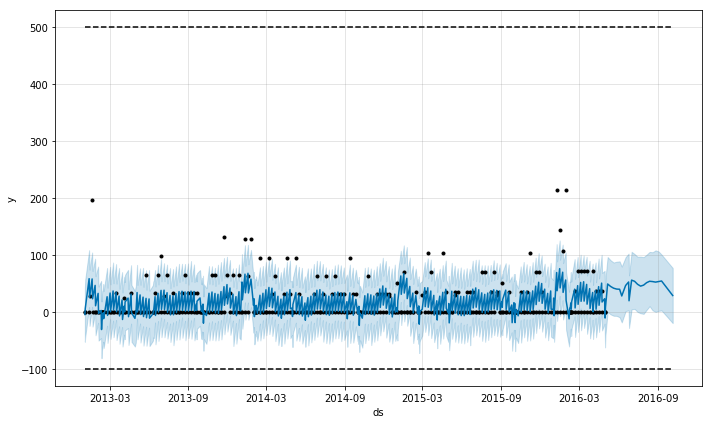

In [304]:
print(forcast_brand3_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand3_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand3_restday.ds < '2016-01-10') & (forcast_brand3_restday.ds > '2016-01-01')])
m_brand3_restday.plot(forcast_brand3_restday)

In [305]:
df_brand3_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 3) 
                                          & (train_data.date_property == 0)]
df_brand3_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand3_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand3_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 3) & (test_data.date_property == 0)]
m_brand3_workday, forcast_brand3_workday = predictByProphet(df_brand3_workday, test_data_brand3_workday, holidays, 1500, -200, 1000, 0.5,
                0.95, df_brand3_workday_regressor_set, brand3_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
840 2016-05-17  352.222285  145.941668  570.619224
841 2016-05-18  316.328254  105.115687  537.947847
842 2016-05-19  249.745381   25.433359  458.040833
843 2016-05-20  291.351720   72.715071  524.377109
844 2016-05-23  337.540193  129.428336  548.468039
845 2016-05-24  339.826898  108.605169  569.861188
846 2016-05-25  304.545015   78.414886  529.713070
847 2016-05-26  238.782289   24.260387  449.119801
848 2016-05-27  281.375678   71.735579  496.992568
849 2016-05-30  331.079804  120.106443  545.632410
850 2016-05-31  334.572542  115.822772  551.559075
851 2016-06-01  300.442551   82.839506  515.504139
852 2016-06-02  235.740075    4.430451  446.634557
853 2016-06-03  279.269635   58.653322  508.868107
854 2016-06-06  330.806680  132.338172  541.580157
855 2016-06-07  334.542932  115.229947  544.629265
856 2016-06-08  300.469744   85.980054  512.893634
857 2016-06-12  391.464375  179.242120  610.372270
858 2016-06-13  292.492930   78

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


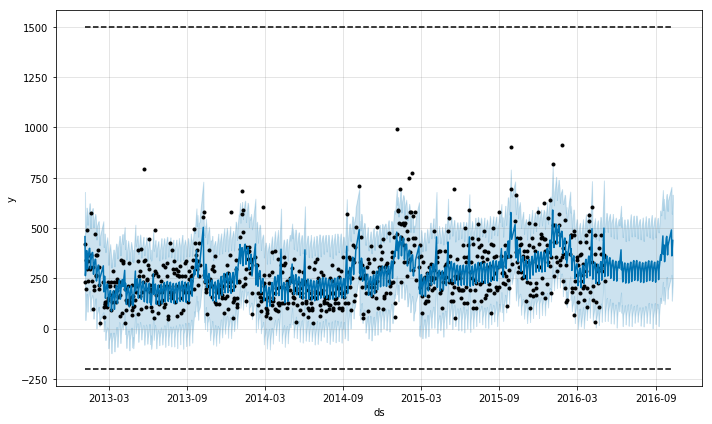

In [306]:
print(forcast_brand3_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand3_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand3_workday.ds < '2016-01-10') & (forcast_brand3_workday.ds > '2016-01-01')])
m_brand3_workday.plot(forcast_brand3_workday)

In [307]:
brand3_result = pd.concat([forcast_brand3_workday, forcast_brand3_restday])
brand3_result = brand3_result.sort_values(by='ds', ascending=True)
print(brand3_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower  yhat_upper
856 2016-06-08  300.469744   85.980054  512.893634
392 2016-06-09   27.723422  -18.716738   79.373550
857 2016-06-12  391.464375  179.242120  610.372270
858 2016-06-13  292.492930   78.235322  504.526432
859 2016-06-14  331.902958  117.835317  553.325844
860 2016-06-15  297.137989   64.101184  515.939128
861 2016-06-16  231.641268   11.989933  455.022205
862 2016-06-17  274.267070   67.661894  484.163780
393 2016-06-18   46.138412    1.154217   95.904925
863 2016-06-20  322.978472   95.422885  542.915629
864 2016-06-21  325.916673  115.526595  520.403256
865 2016-06-22  291.201942   77.209129  511.593723
866 2016-06-23  225.936487   20.163973  434.656243
867 2016-06-24  268.975984   64.216565  489.952852
394 2016-06-25   52.270686    2.461647  102.092449
395 2016-06-26   19.284874  -28.510477   63.876747
868 2016-06-27  319.939629  108.382902  544.486645
869 2016-06-28  323.907373  120.552312  532.593878
870 2016-06-29  290.319187   76

In [308]:
df_brand4_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 4) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand4_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand4_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand4_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 4) & (test_data.date_property != 0)]
m_brand4_restday, forcast_brand4_restday = predictByProphet(df_brand4_restday, test_data_brand4_restday, holidays, 500, -100, 200, 0.5,
                0.95, df_brand4_restday_regressor_set, brand4_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
309 2015-09-12  56.542129   10.124379  101.469132
310 2015-09-13   9.751175  -38.393973   56.497158
311 2015-09-19  56.982334    7.649608   99.428125
312 2015-09-20   9.954087  -35.173934   54.917086
313 2015-09-26  23.755696  -19.539350   71.573482
314 2015-09-27 -24.608044  -72.502822   21.813600
315 2015-10-01  10.068772  -37.841078   49.454644
316 2015-10-02   3.713882  -40.529068   50.183057
317 2015-10-03  27.061631  -16.724898   69.912943
318 2015-10-04 -19.970459  -64.917637   27.641948
319 2015-10-05   7.411234  -40.790938   51.784021
320 2015-10-06   8.048525  -39.269818   54.382610
321 2015-10-07   9.513918  -33.738286   52.186780
322 2015-10-11   7.392100  -35.719254   58.847650
323 2015-10-17  53.442986    7.496470   96.450140
324 2015-10-18   6.154276  -37.555428   49.522606
325 2015-10-24  49.737081    3.387468   97.895706
326 2015-10-25   2.070991  -48.946303   46.142083
327 2015-10-31  44.971177   -5.251342   90.051375


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


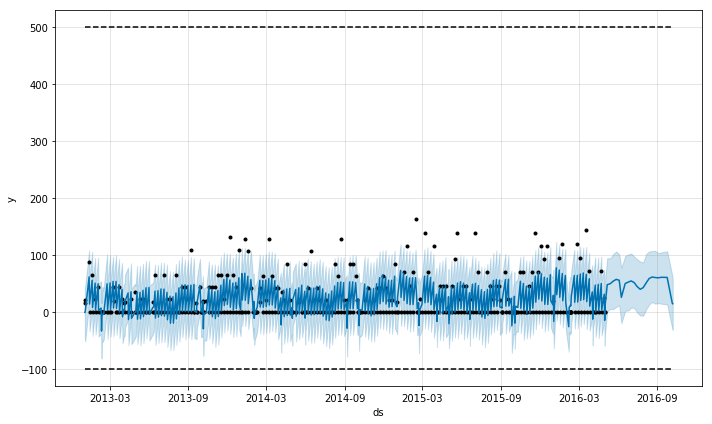

In [309]:
print(forcast_brand4_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand4_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand4_restday.ds < '2016-01-10') & (forcast_brand4_restday.ds > '2016-01-01')])
m_brand4_restday.plot(forcast_brand4_restday)

In [310]:
df_brand4_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 4) 
                                          & (train_data.date_property == 0)]
df_brand4_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand4_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand4_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 4) & (test_data.date_property == 0)]
m_brand4_workday, forcast_brand4_workday = predictByProphet(df_brand4_workday, test_data_brand4_workday, holidays, 1500, -200, 1300, 0.5,
                0.95, df_brand4_workday_regressor_set, brand4_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower   yhat_upper
841 2016-05-18  467.255814  218.628500   735.754162
842 2016-05-19  336.715155   77.061238   608.741938
843 2016-05-20  388.966964  127.266601   651.416397
844 2016-05-23  486.801354  228.697104   750.018754
845 2016-05-24  541.436382  285.638377   816.218107
846 2016-05-25  433.259123  179.712798   681.263477
847 2016-05-26  306.278319   35.100104   558.420433
848 2016-05-27  362.243833   98.489608   643.810334
849 2016-05-30  471.360415  209.134512   735.918730
850 2016-05-31  529.571018  273.428723   789.489525
851 2016-06-01  424.779861  151.636595   699.073897
852 2016-06-02  300.951168   41.734230   558.052993
853 2016-06-03  359.800137  109.135890   630.149834
854 2016-06-06  475.756519  218.179980   726.112891
855 2016-06-07  535.623877  275.874349   799.114938
856 2016-06-08  432.188706  173.073677   695.526295
857 2016-06-12  578.426316  314.032886   840.456893
858 2016-06-13  505.410910  238.065437   775.385001
859 2016-06-

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


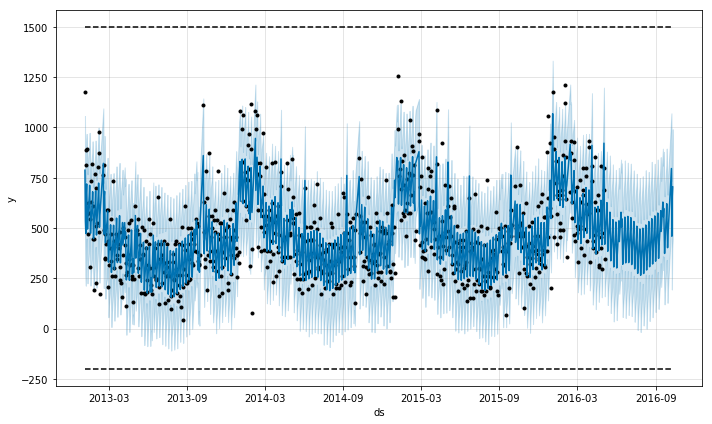

In [311]:
print(forcast_brand4_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand4_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand4_workday.ds < '2016-01-10') & (forcast_brand4_workday.ds > '2016-01-01')])
m_brand4_workday.plot(forcast_brand4_workday)

In [312]:
brand4_result = pd.concat([forcast_brand4_workday, forcast_brand4_restday])
brand4_result = brand4_result.sort_values(by='ds', ascending=True)
print(brand4_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower   yhat_upper
857 2016-06-12  578.426316  314.032886   840.456893
858 2016-06-13  505.410910  238.065437   775.385001
859 2016-06-14  546.065142  292.150052   821.259944
860 2016-06-15  442.535941  171.382592   693.264081
861 2016-06-16  319.584150   56.929017   576.332589
862 2016-06-17  378.967608  109.301558   632.149020
393 2016-06-18   49.655358    1.756309    97.944519
863 2016-06-20  494.884185  212.466973   740.674081
864 2016-06-21  554.311213  285.452093   836.047937
865 2016-06-22  450.270058  178.929454   701.573968
866 2016-06-23  326.761250   52.604429   593.276764
867 2016-06-24  385.534853  112.627281   646.381866
394 2016-06-25   52.067657    2.213110   100.588688
868 2016-06-27  499.197597  236.656983   767.609069
869 2016-06-28  557.692915  285.222008   825.067586
870 2016-06-29  452.612129  184.260052   723.388519
871 2016-06-30  327.948235   67.434221   586.108518
872 2016-07-01  385.447022  126.149682   661.921436
395 2016-07-

In [313]:
df_brand6_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 6) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand6_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand6_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand6_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 6) & (test_data.date_property != 0)]
m_brand6_restday, forcast_brand6_restday = predictByProphet(df_brand6_restday, test_data_brand6_restday, holidays, 500, -100, 200, 0.5,
                0.95, df_brand6_restday_regressor_set, brand6_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
313 2015-09-20   5.633248  -28.411765   39.838252
314 2015-09-26  23.315247   -9.470177   56.544698
315 2015-09-27 -13.266382  -46.379974   20.822121
316 2015-10-01   3.466094  -31.150994   38.622031
317 2015-10-02   3.653770  -30.379441   39.270389
318 2015-10-03  23.933910   -8.545756   56.889905
319 2015-10-04 -12.806296  -49.314843   21.144346
320 2015-10-05   6.271087  -30.470355   42.177665
321 2015-10-06  12.153155  -19.698057   47.204270
322 2015-10-07  15.757534  -18.435782   50.514313
323 2015-10-11   7.513764  -31.088585   37.841611
324 2015-10-17  43.093118   11.695582   74.605422
325 2015-10-18   6.061308  -27.532343   39.819165
326 2015-10-24  40.922892    6.676584   74.102661
327 2015-10-25   3.824885  -31.541960   38.305672
328 2015-10-31  38.886997    3.740123   70.290079
329 2015-11-01   1.938762  -31.528368   38.140727
330 2015-11-07  38.500086    0.446535   74.663001
331 2015-11-08   1.860410  -32.802654   35.317664


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


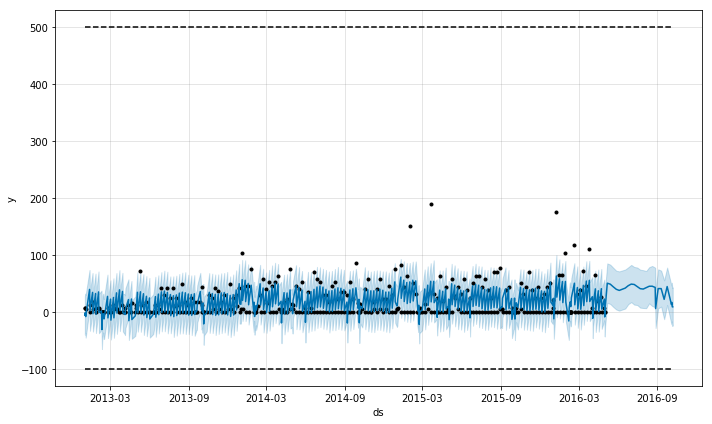

In [314]:
print(forcast_brand6_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand6_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand6_restday.ds < '2016-01-10') & (forcast_brand6_restday.ds > '2016-01-01')])
m_brand6_restday.plot(forcast_brand6_restday)

In [315]:
df_brand6_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 6) 
                                          & (train_data.date_property == 0)]
df_brand6_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand6_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand6_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 6) & (test_data.date_property == 0)]
m_brand6_workday, forcast_brand6_workday = predictByProphet(df_brand6_workday, test_data_brand6_workday, holidays, 1000, -200, 700, 0.5,
                0.95, df_brand6_workday_regressor_set, brand6_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
841 2016-05-18  312.986326  178.860082  444.490825
842 2016-05-19  264.467596  123.161082  400.970701
843 2016-05-20  302.969736  161.776764  448.109048
844 2016-05-23  296.613988  144.554261  428.727514
845 2016-05-24  326.829391  182.861170  470.044094
846 2016-05-25  300.169145  157.339659  436.039538
847 2016-05-26  251.283845  114.381318  389.540418
848 2016-05-27  289.560094  148.167901  416.795390
849 2016-05-30  283.311740  154.041302  426.105035
850 2016-05-31  313.801444  177.058858  455.791826
851 2016-06-01  287.522357  157.473498  422.574030
852 2016-06-02  239.117637   96.191739  375.275964
853 2016-06-03  277.966666  133.798601  418.880450
854 2016-06-06  273.922590  146.019398  411.408779
855 2016-06-07  305.288290  166.788454  438.229411
856 2016-06-08  279.946078  138.126612  417.015919
857 2016-06-12  336.034128  200.050176  475.754240
858 2016-06-13  294.501003  161.749645  436.093207
859 2016-06-14  304.273204  158

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


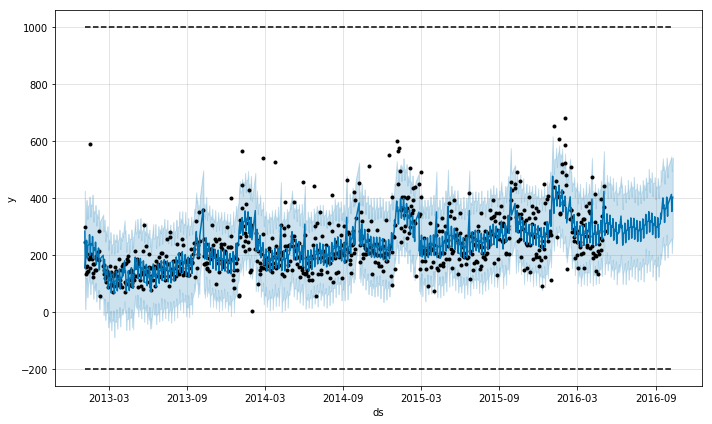

In [316]:
print(forcast_brand6_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand6_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand6_workday.ds < '2016-01-10') & (forcast_brand6_workday.ds > '2016-01-01')])
m_brand6_workday.plot(forcast_brand6_workday)

In [317]:
brand6_result = pd.concat([forcast_brand6_workday, forcast_brand6_restday])
brand6_result = brand6_result.sort_values(by='ds', ascending=True)
print(brand6_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower  yhat_upper
861 2016-06-16  233.887727   97.843914  360.356138
862 2016-06-17  274.954673  134.979875  414.385862
393 2016-06-18   41.562039    5.702478   74.201197
863 2016-06-20  277.614167  155.855851  413.656497
864 2016-06-21  311.159813  170.501047  444.382253
865 2016-06-22  287.931088  146.948535  416.501763
866 2016-06-23  242.540132   97.407093  384.817278
867 2016-06-24  284.334382  140.465620  416.457423
394 2016-06-25   45.797950   13.323901   78.070073
868 2016-06-27  288.386723  157.670528  420.423095
869 2016-06-28  322.095195  178.924629  462.317955
870 2016-06-29  298.864433  147.369522  436.907821
871 2016-06-30  253.301987  112.504112  396.876765
872 2016-07-01  294.753797  152.041475  422.974729
395 2016-07-02   48.586383   16.905288   82.302533
873 2016-07-04  296.789679  148.467256  437.787893
874 2016-07-05  329.526684  194.879439  457.811031
875 2016-07-06  305.199176  165.671865  444.912226
876 2016-07-07  258.434607  123

In [318]:
df_brand7_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 7) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand7_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand7_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand7_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 7) & (test_data.date_property != 0)]
m_brand7_restday, forcast_brand7_restday = predictByProphet(df_brand7_restday, test_data_brand7_restday, holidays, 500, -100, 200, 0.5,
                0.95, df_brand7_restday_regressor_set, brand7_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
306 2015-09-03   5.237209  -49.713069   61.446860
307 2015-09-04   6.462741  -55.008586   69.025699
308 2015-09-05  20.163507  -38.184209   82.623865
309 2015-09-12  48.085312  -15.804556  104.436454
310 2015-09-13   3.196386  -58.924749   66.759530
311 2015-09-19  52.550008  -10.751404  111.483364
312 2015-09-20   8.266037  -51.995393   71.283200
313 2015-09-26  28.340397  -32.213849   92.828991
314 2015-09-27 -11.206142  -74.730429   46.552975
315 2015-10-01   9.863204  -47.831877   71.844929
316 2015-10-02  18.597728  -39.621816   79.628213
317 2015-10-03  33.363713  -26.253589   97.066600
318 2015-10-04 -11.725396  -76.168728   47.819856
319 2015-10-05  11.681319  -47.560241   70.519229
320 2015-10-06  15.023776  -44.207936   77.010603
321 2015-10-07  14.887098  -45.129278   76.885040
322 2015-10-11  16.018626  -43.062921   73.188432
323 2015-10-17  60.706781   -1.198913  120.000130
324 2015-10-18  15.400617  -45.242668   79.227591


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


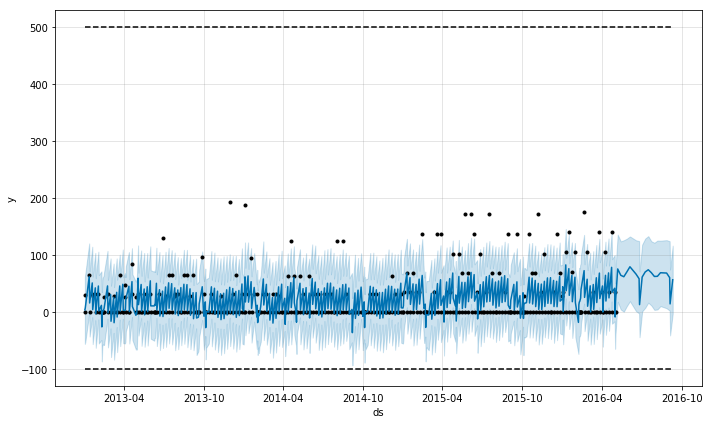

In [319]:
print(forcast_brand7_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand7_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand7_restday.ds < '2016-01-10') & (forcast_brand7_restday.ds > '2016-01-01')])
m_brand7_restday.plot(forcast_brand7_restday)

In [320]:
df_brand7_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 7) 
                                          & (train_data.date_property == 0)]
df_brand7_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand7_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand7_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 7) & (test_data.date_property == 0)]
m_brand7_workday, forcast_brand7_workday = predictByProphet(df_brand7_workday, test_data_brand7_workday, holidays, 1000, -200, 750, 0.5,
                0.95, df_brand7_workday_regressor_set, brand7_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
841 2016-05-17  414.131122  200.281716  629.812723
842 2016-05-18  377.451163  153.760300  599.245015
843 2016-05-19  329.897745  106.726101  545.579378
844 2016-05-20  370.244022  143.729312  586.625414
845 2016-05-23  377.387597  145.322798  585.970769
846 2016-05-24  423.383011  200.633492  641.100890
847 2016-05-25  386.385924  166.030117  597.860841
848 2016-05-26  338.450468  124.338162  566.297031
849 2016-05-27  378.333603  163.511422  603.503315
850 2016-05-30  383.469378  171.301742  611.163355
851 2016-05-31  428.560460  213.078730  630.331857
852 2016-06-01  390.536543  179.470662  603.868246
853 2016-06-02  341.455359  123.902979  561.613879
854 2016-06-03  380.082168  164.816253  596.781494
855 2016-06-06  380.938190  160.345148  589.259578
856 2016-06-07  424.504856  199.699947  637.745306
857 2016-06-08  384.952951  156.974434  619.257928
858 2016-06-12  352.546040  144.484451  573.818037
859 2016-06-13  391.533121  188

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


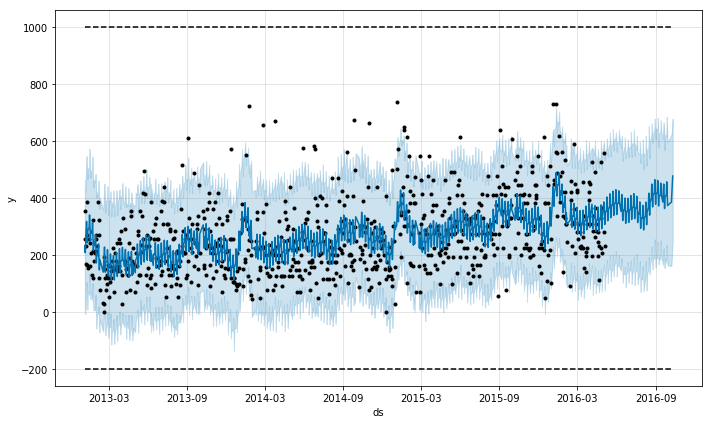

In [321]:
print(forcast_brand7_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand7_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand7_workday.ds < '2016-01-10') & (forcast_brand7_workday.ds > '2016-01-01')])
m_brand7_workday.plot(forcast_brand7_workday)

In [322]:
brand7_result = pd.concat([forcast_brand7_workday, forcast_brand7_restday])
brand7_result = brand7_result.sort_values(by='ds', ascending=True)
print(brand7_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower  yhat_upper
855 2016-06-06  380.938190  160.345148  589.259578
856 2016-06-07  424.504856  199.699947  637.745306
857 2016-06-08  384.952951  156.974434  619.257928
858 2016-06-12  352.546040  144.484451  573.818037
859 2016-06-13  391.533121  188.133794  606.567901
860 2016-06-14  411.490792  170.229496  617.453040
861 2016-06-15  371.285013  157.835502  576.719603
862 2016-06-16  320.287095  102.039641  530.081228
863 2016-06-17  357.312194  134.971035  558.872284
392 2016-06-18   66.087211    1.003093  125.437541
864 2016-06-20  355.666849  132.255961  581.250344
865 2016-06-21  399.266974  158.368497  612.031277
866 2016-06-22  360.208316  143.363091  567.109368
867 2016-06-23  310.579630   85.052968  539.644328
868 2016-06-24  349.167397  128.917836  554.817170
393 2016-06-25   57.964354   -2.838747  124.178570
394 2016-06-26   12.484591  -44.712017   70.706232
869 2016-06-27  353.001675  146.828384  575.112117
870 2016-06-28  398.547743  174

In [323]:
df_brand8_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 8) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand8_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand8_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand8_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 8) & (test_data.date_property != 0)]
m_brand8_restday, forcast_brand8_restday = predictByProphet(df_brand8_restday, test_data_brand8_restday, holidays, 500, -100, 200, 0.5,
                0.95, df_brand8_restday_regressor_set, brand8_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
308 2015-09-05  16.460132  -24.492908   61.426713
309 2015-09-12  29.330302  -15.193840   74.630679
310 2015-09-13   7.593573  -36.441296   53.831647
311 2015-09-19  28.199072  -12.757926   71.086781
312 2015-09-20   6.697199  -35.037010   52.110648
313 2015-09-26  13.235987  -26.274756   56.093455
314 2015-09-27  -4.796540  -46.103140   43.940827
315 2015-10-01  20.059692  -22.222827   63.498788
316 2015-10-02  10.877257  -32.333576   55.392471
317 2015-10-03  19.569405  -24.469331   64.239529
318 2015-10-04  -1.385481  -46.469415   43.662662
319 2015-10-05  12.177379  -29.409819   56.679348
320 2015-10-06  15.731979  -29.271531   58.910332
321 2015-10-07  25.613871  -20.267301   74.246643
322 2015-10-11  14.940050  -28.372001   56.663105
323 2015-10-17  41.050480   -6.046135   84.329054
324 2015-10-18  20.303890  -22.485057   64.454168
325 2015-10-24  45.221498    3.805672   89.731831
326 2015-10-25  24.105193  -22.097697   66.829213


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


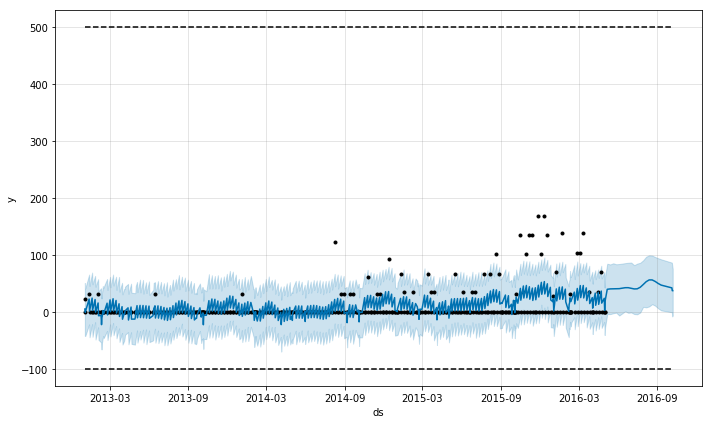

In [324]:
print(forcast_brand8_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand8_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand8_restday.ds < '2016-01-10') & (forcast_brand8_restday.ds > '2016-01-01')])
m_brand8_restday.plot(forcast_brand8_restday)

In [325]:
df_brand8_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 8) 
                                          & (train_data.date_property == 0)]
df_brand8_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand8_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand8_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 8) & (test_data.date_property == 0)]
m_brand8_workday, forcast_brand8_workday = predictByProphet(df_brand8_workday, test_data_brand8_workday, holidays, 800, -300, 800, 0.5,
                0.95, df_brand8_workday_regressor_set, brand8_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
839 2016-05-16  468.476964  305.528986  640.925935
840 2016-05-17  481.468385  306.500147  642.788848
841 2016-05-18  447.405666  266.458811  617.243546
842 2016-05-19  406.047405  240.281927  576.375507
843 2016-05-20  424.613904  252.076933  598.673718
844 2016-05-23  454.541940  270.334809  623.264303
845 2016-05-24  469.013342  288.701057  627.138825
846 2016-05-25  436.597786  259.275245  619.245770
847 2016-05-26  397.007577  226.670525  584.100055
848 2016-05-27  417.414230  253.961212  585.868103
849 2016-05-30  452.799013  303.591750  636.396907
850 2016-05-31  468.909550  298.617224  640.565264
851 2016-06-01  437.972094  270.021664  610.130788
852 2016-06-02  399.663692  227.271532  589.803245
853 2016-06-03  421.127007  250.295527  592.674197
854 2016-06-06  458.153688  289.283232  628.735192
855 2016-06-07  474.283277  304.691290  643.527120
856 2016-06-08  443.111837  280.991211  620.700816
857 2016-06-12  524.105623  353

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


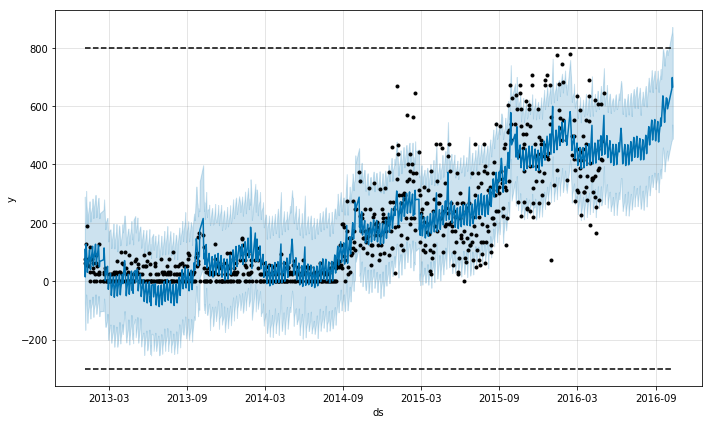

In [326]:
print(forcast_brand8_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand8_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand8_workday.ds < '2016-01-10') & (forcast_brand8_workday.ds > '2016-01-01')])
m_brand8_workday.plot(forcast_brand8_workday)

In [327]:
brand8_result = pd.concat([forcast_brand8_workday, forcast_brand8_restday])
brand8_result = brand8_result.sort_values(by='ds', ascending=True)
print(brand8_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower  yhat_upper
855 2016-06-07  474.283277  304.691290  643.527120
856 2016-06-08  443.111837  280.991211  620.700816
857 2016-06-12  524.105623  353.566589  686.697523
858 2016-06-13  503.354023  353.257342  678.815123
859 2016-06-14  474.200565  296.012677  651.082103
860 2016-06-15  441.882166  268.337063  598.413505
861 2016-06-16  401.999453  240.883875  573.036809
862 2016-06-17  421.766241  250.649995  592.286058
392 2016-06-18   42.231333    0.906064   85.392034
863 2016-06-20  453.723338  279.088300  626.907825
864 2016-06-21  468.418236  298.538696  623.179143
865 2016-06-22  436.054438  262.747237  602.522109
866 2016-06-23  396.386055  225.671266  564.934237
867 2016-06-24  416.630386  243.837977  589.642559
393 2016-06-25   42.274602   -1.854778   86.075659
868 2016-06-27  451.506528  278.252207  630.839754
869 2016-06-28  467.598008  307.168727  641.782012
870 2016-06-29  436.788137  268.135876  605.454814
871 2016-06-30  398.789110  224

In [328]:
df_brand10_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 10) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand10_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand10_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand10_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 10) & (test_data.date_property != 0)]
m_brand10_restday, forcast_brand10_restday = predictByProphet(df_brand10_restday, test_data_brand10_restday, holidays, 500, -100, 180, 0.5,
                0.95, df_brand10_restday_regressor_set, brand10_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
308 2015-09-05  20.401861  -26.489450   65.366085
309 2015-09-12  58.584593   11.056901  106.056691
310 2015-09-13  15.502394  -30.862040   62.253637
311 2015-09-19  61.769937   15.188498  107.717928
312 2015-09-20  18.212269  -31.353574   66.108829
313 2015-09-26  25.705114  -19.374972   75.839725
314 2015-09-27 -18.854385  -63.609600   24.668798
315 2015-10-01  11.967233  -39.909724   55.817108
316 2015-10-02   3.497508  -42.690898   51.894275
317 2015-10-03  30.408316  -14.054927   77.225640
318 2015-10-04 -14.706312  -64.661088   33.791221
319 2015-10-05   5.687541  -42.274119   50.298306
320 2015-10-06   3.151682  -46.395009   45.691002
321 2015-10-07  19.522813  -27.279037   69.617821
322 2015-10-11  -2.482224  -46.951685   44.117992
323 2015-10-17  38.963145   -7.460808   83.728186
324 2015-10-18  -4.522363  -51.307249   44.012765
325 2015-10-24  42.741154   -6.082876   89.104933
326 2015-10-25  -0.087174  -45.741626   47.052820


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


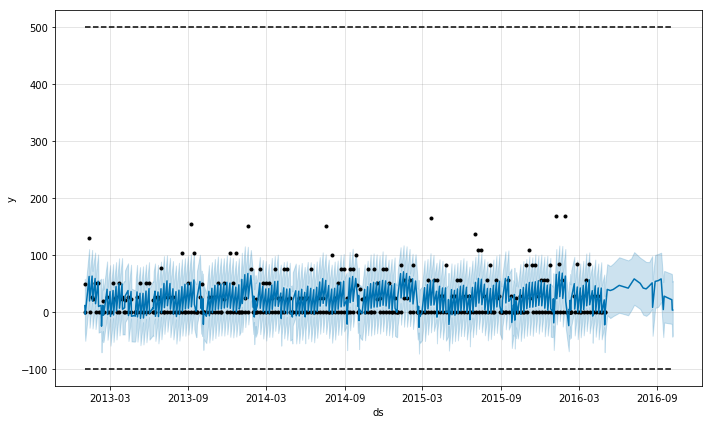

In [329]:
print(forcast_brand10_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand10_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand10_restday.ds < '2016-01-10') & (forcast_brand10_restday.ds > '2016-01-01')])
m_brand10_restday.plot(forcast_brand10_restday)

In [330]:
df_brand10_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 10) 
                                          & (train_data.date_property == 0)]
df_brand10_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand10_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand10_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 10) & (test_data.date_property == 0)]
m_brand10_workday, forcast_brand10_workday = predictByProphet(df_brand10_workday, test_data_brand10_workday, holidays, 1500, 200, 2000, 0.5,
                0.95, df_brand10_workday_regressor_set, brand10_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower   yhat_upper
840 2016-05-17  412.929372   77.325076   746.698668
841 2016-05-18  370.052415   19.653774   714.415916
842 2016-05-19  278.170995  -73.871294   617.040132
843 2016-05-20  342.855657   -3.864206   653.506884
844 2016-05-23  414.581318   56.935008   758.808433
845 2016-05-24  383.980706   55.194826   711.274167
846 2016-05-25  338.390124   23.796008   664.905793
847 2016-05-26  243.931062  -96.067935   567.915972
848 2016-05-27  306.187918  -27.699727   632.131658
849 2016-05-30  371.714750   27.333127   688.248862
850 2016-05-31  339.487607    5.953320   678.002051
851 2016-06-01  292.537037  -40.463911   646.689967
852 2016-06-02  197.016102 -136.701498   542.618851
853 2016-06-03  258.542138 -101.475640   594.611505
854 2016-06-06  324.191119   -1.387655   631.320639
855 2016-06-07  292.876943  -38.374467   636.001043
856 2016-06-08  247.316901  -94.353550   591.091929
857 2016-06-12  625.189351  267.695459   965.410852
858 2016-06-

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


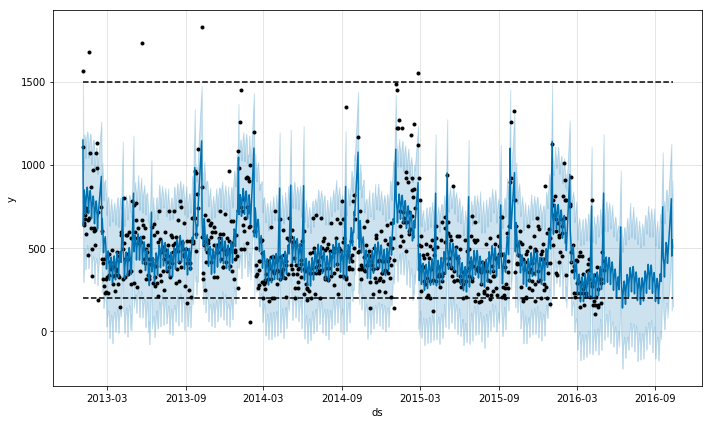

In [331]:
print(forcast_brand10_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand10_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand10_workday.ds < '2016-01-10') & (forcast_brand10_workday.ds > '2016-01-01')])
m_brand10_workday.plot(forcast_brand10_workday)

In [332]:
brand10_result = pd.concat([forcast_brand10_workday, forcast_brand10_restday])
brand10_result = brand10_result.sort_values(by='ds', ascending=True)
print(brand10_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower   yhat_upper
857 2016-06-12  625.189351  267.695459   965.410852
858 2016-06-13  303.521546  -20.096677   640.137151
859 2016-06-14  266.396694  -65.428227   603.111326
860 2016-06-15  225.560940 -110.981050   554.189330
861 2016-06-16  137.005918 -227.932345   475.467700
862 2016-06-17  206.296381 -114.047614   537.785413
863 2016-06-20  299.228159  -35.853250   620.465677
864 2016-06-21  277.981353  -67.642322   624.411546
865 2016-06-22  242.755740  -88.255849   581.602152
866 2016-06-23  159.568390 -163.873201   519.091972
867 2016-06-24  233.882797  -91.694103   577.753370
391 2016-06-25   41.458382   -6.169929    90.213713
868 2016-06-27  338.862636  -40.934077   679.774321
869 2016-06-28  320.337417  -35.139200   664.582525
870 2016-06-29  287.068049  -80.122498   600.143495
871 2016-06-30  205.020272 -113.293977   551.441801
872 2016-07-01  279.621839  -70.179664   617.639840
392 2016-07-02   49.669357    2.362106    93.885222
873 2016-07-

In [333]:
df_brand5_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 5) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand5_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand5_changepoints_restday = ['2014-10-01', '2015-10-01']
test_data_brand5_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 5) & (test_data.date_property != 0)]
m_brand5_restday, forcast_brand5_restday = predictByProphet(df_brand5_restday, test_data_brand5_restday, holidays, 200, -100, 200, 0.5,
                0.95, df_brand5_restday_regressor_set, brand5_changepoints_restday)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
135 2015-09-05  14.504903  -29.863783   56.926703
136 2015-09-12  32.129562  -11.199157   79.758269
137 2015-09-13   5.723288  -36.537303   50.355576
138 2015-09-19  32.376471  -11.881556   74.841022
139 2015-09-20   5.970187  -37.051478   50.682193
140 2015-09-26  15.245630  -27.471249   56.710696
141 2015-09-27  -6.905480  -51.911736   37.327847
142 2015-10-01  12.660574  -31.004383   56.517780
143 2015-10-02   9.075781  -37.078605   54.890689
144 2015-10-03  20.675471  -23.078097   66.410697
145 2015-10-04  -5.717890  -50.992262   39.118367
146 2015-10-05   5.287729  -35.622519   48.495885
147 2015-10-06   6.971719  -37.748101   52.766548
148 2015-10-07   7.113513  -38.197107   51.425240
149 2015-10-11   6.839862  -36.515302   50.038440
150 2015-10-17  33.570375  -11.352786   77.563858
151 2015-10-18   7.176974  -41.894958   49.442591
152 2015-10-24  33.907362   -9.413259   79.383024
153 2015-10-25   7.513939  -41.465339   50.982617


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


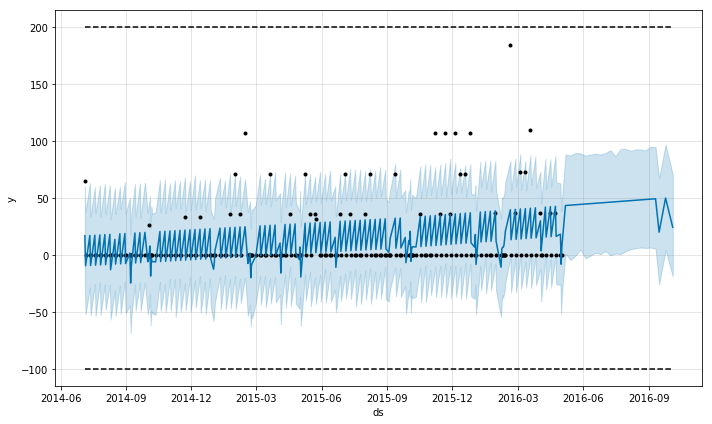

In [334]:
print(forcast_brand5_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand5_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand5_restday.ds < '2016-01-10') & (forcast_brand5_restday.ds > '2016-01-01')])
m_brand5_restday.plot(forcast_brand5_restday)

In [335]:
df_brand5_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 5) 
                                          & (train_data.date_property == 0)]
df_brand5_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand5_changepoints_workday = ['2014-10-01', '2015-10-01']
test_data_brand5_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 5) & (test_data.date_property == 0)]
m_brand5_workday, forcast_brand5_workday = predictByProphet(df_brand5_workday, test_data_brand5_workday, holidays, 1500, -100, 1500, 0.5,
                0.95, df_brand5_workday_regressor_set, brand5_changepoints_workday)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower   yhat_upper
463 2016-05-13  437.997734  164.135308   714.609867
464 2016-05-16  535.861361  253.264773   825.356938
465 2016-05-17  500.741429  200.788425   786.192627
466 2016-05-18  460.348006  176.123701   726.399623
467 2016-05-19  400.505716  112.992836   685.541251
468 2016-05-20  441.321674  164.131741   723.472510
469 2016-05-23  539.163995  247.477164   849.613589
470 2016-05-24  504.036980  199.428500   797.495760
471 2016-05-25  463.636484  155.680544   730.340021
472 2016-05-26  403.787131   90.036824   698.439915
473 2016-05-27  444.596035  168.035411   708.200702
474 2016-05-30  542.417254  233.902376   815.237248
475 2016-05-31  507.283225  230.012051   779.898114
476 2016-06-01  466.875725  168.124106   755.995351
477 2016-06-02  407.019377  120.049318   684.769369
478 2016-06-03  447.821297  154.932614   728.125430
479 2016-06-06  545.621622  260.872404   842.906169
480 2016-06-07  510.480648  227.069273   810.580550
481 2016-06-

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


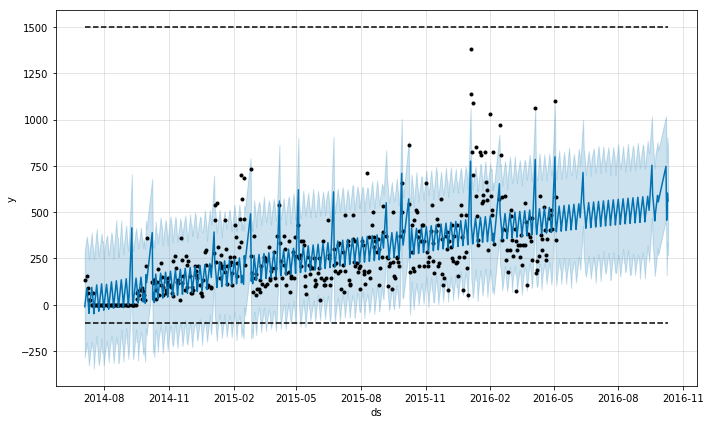

In [336]:
print(forcast_brand5_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand5_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand5_workday.ds < '2016-01-10') & (forcast_brand5_workday.ds > '2016-01-01')])
m_brand5_workday.plot(forcast_brand5_workday)

In [337]:
brand5_result = pd.concat([forcast_brand5_workday, forcast_brand5_restday])
brand5_result = brand5_result.sort_values(by='ds', ascending=True)
print(brand5_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower   yhat_upper
479 2016-06-06  545.621622  260.872404   842.906169
480 2016-06-07  510.480648  227.069273   810.580550
481 2016-06-08  470.066212  187.997387   752.649651
482 2016-06-12  714.264005  426.042486   999.373523
483 2016-06-13  556.628523  258.159274   843.784950
484 2016-06-14  513.629733  225.403062   809.874060
485 2016-06-15  473.208432  175.034817   759.864976
486 2016-06-16  413.338304  151.485043   700.388035
487 2016-06-17  454.126463  171.953884   742.964383
219 2016-06-18   45.254185    1.800962    88.789485
488 2016-06-20  551.885626  264.205990   829.934491
489 2016-06-21  516.730971  218.992026   792.101545
490 2016-06-22  476.302875  189.391475   760.744972
491 2016-06-23  416.425962  140.581781   695.919113
492 2016-06-24  457.207346  174.499992   782.923099
220 2016-06-25   45.583979    0.628824    87.987476
493 2016-06-27  554.946245  262.557939   844.849321
494 2016-06-28  519.784856  216.778569   814.078313
495 2016-06-

In [338]:
#将分品牌预测出来的结果合并
def fillPredictResult(df_test_data, df_fill_data, brand):
    df_test_data['predict_result'][df_test_data.brand == brand] = df_fill_data['yhat'].values
    return df_test_data

test_data['predict_result'] = 10
test_data = fillPredictResult(test_data, brand1_result[(brand1_result.ds < '2016-10-12') & (brand1_result.ds > '2016-05-05')], 1)
test_data = fillPredictResult(test_data, brand2_result[(brand2_result.ds < '2016-10-12') & (brand2_result.ds > '2016-05-05')], 2)
test_data = fillPredictResult(test_data, brand3_result[(brand3_result.ds < '2016-10-12') & (brand3_result.ds > '2016-05-05')], 3)
test_data = fillPredictResult(test_data, brand4_result[(brand4_result.ds < '2016-10-12') & (brand4_result.ds > '2016-05-05')], 4)
test_data = fillPredictResult(test_data, brand5_result[(brand5_result.ds < '2016-10-12') & (brand5_result.ds > '2016-05-05')], 5)
test_data = fillPredictResult(test_data, brand6_result[(brand6_result.ds < '2016-10-12') & (brand6_result.ds > '2016-05-05')], 6)
brand7_result = brand7_result.drop_duplicates(['ds'])
test_data = fillPredictResult(test_data, brand7_result[(brand7_result.ds < '2016-10-12') & (brand7_result.ds > '2016-05-04')], 7)
test_data = fillPredictResult(test_data, brand8_result[(brand8_result.ds < '2016-10-12') & (brand8_result.ds > '2016-05-04')], 8)
test_data = fillPredictResult(test_data, brand9_result[(brand9_result.ds < '2016-10-12') & (brand9_result.ds > '2016-05-04')], 9)
test_data = fillPredictResult(test_data, brand10_result[(brand10_result.ds < '2016-10-12') & (brand10_result.ds > '2016-05-04')], 10)
# print(len(test_data['predict_result'][test_data.brand == 7]))
# print(len(brand7_result[(brand7_result.ds < '2016-10-12') & (brand7_result.ds > '2016-05-04')]))
print(test_data[['ds', 'brand', 'day_of_week', 'date', 'predict_result']].head(100))

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


           ds  brand  day_of_week  date  predict_result
0  2016-05-05      7            4  1107      306.508052
1  2016-05-05      8            4  1107      435.058914
2  2016-05-05      9            4  1107      391.314679
3  2016-05-05     10            4  1107      281.115530
4  2016-05-06      1            5  1108      379.957494
5  2016-05-06      2            5  1108      291.314494
6  2016-05-06      3            5  1108      303.636424
7  2016-05-06      4            5  1108      474.353270
8  2016-05-06      5            5  1108      434.623741
9  2016-05-06      6            5  1108      309.784373
10 2016-05-06      7            5  1108      347.519873
11 2016-05-06      8            5  1108      454.890223
12 2016-05-06      9            5  1108      498.495481
13 2016-05-06     10            5  1108      352.589603
14 2016-05-07      1            6  1109       35.405304
15 2016-05-07      2            6  1109       51.339976
16 2016-05-07      3            6  1109       48

In [339]:
#查看组装结果是否正确
brand1_result['brand'] = 1
brand2_result['brand'] = 2
brand3_result['brand'] = 3
brand4_result['brand'] = 4
brand5_result['brand'] = 5
brand6_result['brand'] = 6
brand7_result['brand'] = 7
brand8_result['brand'] = 8
brand9_result['brand'] = 9
brand10_result['brand'] = 10
df_predict_result = pd.concat([brand1_result, brand2_result, brand3_result, brand4_result, brand5_result,
                              brand6_result, brand7_result, brand8_result, brand9_result, brand10_result])
df_predict_result = df_predict_result.sort_values(by=['ds', 'brand'], ascending=True)
print(df_predict_result[['ds', 'brand', 'yhat']][(df_predict_result.ds < '2016-10-12') & (df_predict_result.ds > '2016-05-04')])

            ds  brand        yhat
832 2016-05-05      1  342.193508
832 2016-05-05      2  249.133390
832 2016-05-05      3  258.641479
832 2016-05-05      4  419.193159
457 2016-05-05      5  393.793473
832 2016-05-05      6  268.283402
832 2016-05-05      7  306.508052
832 2016-05-05      8  435.058914
832 2016-05-05      9  391.314679
832 2016-05-05     10  281.115530
833 2016-05-06      1  379.957494
833 2016-05-06      2  291.314494
833 2016-05-06      3  303.636424
833 2016-05-06      4  474.353270
458 2016-05-06      5  434.623741
833 2016-05-06      6  309.784373
834 2016-05-06      7  347.519873
833 2016-05-06      8  454.890223
833 2016-05-06      9  498.495481
833 2016-05-06     10  352.589603
388 2016-05-07      1   35.405304
387 2016-05-07      2   51.339976
387 2016-05-07      3   48.772557
387 2016-05-07      4   47.610331
214 2016-05-07      5   43.270078
388 2016-05-07      6   50.162463
387 2016-05-07      7   75.166897
387 2016-05-07      8   39.458842
388 2016-05-07

In [340]:
# 导出预测结果
def exportResult(df, fileName):
    df.to_csv('./%s.txt' % fileName, sep='\t', header=False, index=False)

#保存预测结果
exportResult(test_data[['date','brand', 'predict_result']], 'prophet_dateProperty_A_fusai_3_6')

In [341]:
#导入A榜答案，计算预测误差
df_fusai_A_answer = pd.read_csv('fusai_answer_a_20180307.txt', sep='\t', header=None)
print(df_fusai_A_answer[2][df_fusai_A_answer[1] == 9].tail(20))

1118      12
1130    1117
1140     884
1150    1707
1160    1141
1170     442
1179     134
1186      67
1195     121
1203     117
1212     109
1221      37
1228      80
1232      17
1235      47
1247      13
1257    1071
1267     798
1277     937
1287    1004
Name: 2, dtype: int64


In [342]:
# 计算模型误差
def calculateError(df_answer, df_predict, brand):
    answer = df_answer[2][df_answer[1] == brand]
    predict = df_predict['predict_result'][df_predict.brand == brand]
    cost = np.linalg.norm(predict - answer)**2 / len(predict)
    print("cost:", cost)
    
calculateError(df_fusai_A_answer, test_data, 5)

cost: 45191.821241


In [343]:
brand5_compare = brand5_result[(brand5_result.ds < '2016-10-12') & (brand5_result.ds > '2016-05-05')]
brand5_compare['answer'] = df_fusai_A_answer[2][df_fusai_A_answer[1] == 5].values
print(brand5_compare[['ds', 'answer', 'yhat']].tail(100))

            ds  answer        yhat
479 2016-06-06     617  545.621622
480 2016-06-07     661  510.480648
481 2016-06-08     377  470.066212
482 2016-06-12     382  714.264005
483 2016-06-13     558  556.628523
484 2016-06-14     257  513.629733
485 2016-06-15     103  473.208432
486 2016-06-16     512  413.338304
487 2016-06-17     264  454.126463
219 2016-06-18      73   45.254185
488 2016-06-20     470  551.885626
489 2016-06-21     294  516.730971
490 2016-06-22     206  476.302875
491 2016-06-23     188  416.425962
492 2016-06-24     176  457.207346
220 2016-06-25      37   45.583979
493 2016-06-27     499  554.946245
494 2016-06-28     441  519.784856
495 2016-06-29     548  479.350036
496 2016-06-30     269  419.466409
497 2016-07-01     147  460.241089
221 2016-07-02     220   45.913509
498 2016-07-04     470  557.959937
499 2016-07-05     404  522.791885
500 2016-07-06     480  482.350412
501 2016-07-07     188  422.460141
502 2016-07-08     588  463.228189
222 2016-07-09     1

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [344]:
all_cost = np.linalg.norm(df_fusai_A_answer[2] - test_data['predict_result'])**2 / len(test_data['predict_result'])
all_cost

31465.122119250649